# Image Processing SS 20 - Assignment - 04

### Deadline is 20.5.2020 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import random
from io import BytesIO
from PIL import Image

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# Exercise 1 - Qualify sharpness and noise - 5 Points

Determine the noise and sharpness in the images. Plot image number vs noise

Please download sample picture from [here](http://sipi.usc.edu/database/misc.zip) and place them next to your assignment (inside the misc folder).

In [3]:
# Load the pictures here
sample_images = []
direc = 'misc/' # directory of the sample pictures relative to your notebook
for number in [1,3,5,6]:
    sample_images.append(
        np.array(Image.open(direc+'4.2.0'+str(number)+'.tiff'))
    )
for name in ['house']:
    sample_images.append(
        np.array(Image.open(direc+name+'.tiff'))
    )

<BarContainer object of 5 artists>

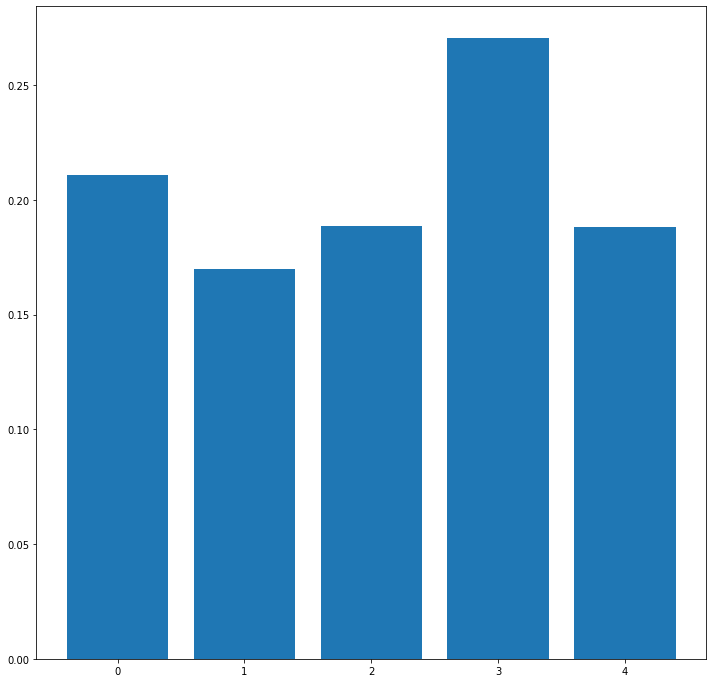

In [4]:
from skimage.color import rgb2grey

def qualify_noise(img):
    """Qualify the noise based on the std of a gaussian model.
       You may find a window that is contant in the images.
    """
    # your code here
    """
    slide 42 lecture "Image Processing"

    How can we measure the amount of noise in an image?
    We don’t know whether the changes of pixel brightness are due to texture or noise!
    Let’s first assume we know where in the image we have a homogeneous patch 
    (i.e.an image region with no texture, edges, gradients, etc).
    
    For estimating Gaussian Noise we have to calculate 2 parameters: sigma und mu
    The parameter mu  is the mean or expectation of the distribution (and also its median and mode); 
    and sigma  is its standard deviation. 
    The variance of the distribution is sigma^2
        
    Numpy function std: Returns the standard deviation, a measure of the spread of a distribution, 
    of the array elements. The standard deviation is computed for the flattened array by default, 
    otherwise over the specified axis.
    """
    grey_img = rgb2grey(img)
    # mu = np.mean(img)
    std = np.std(grey_img, dtype = np.float32) 
    return std
    

plt.bar(range(len(sample_images)), [qualify_noise(i) for i in sample_images])

In [ ]:
def qualify_sharpness(img):
    """Qualify the sharpness based on the average pixel differences."""
    # your code here
    return random.randint(0, 10)
plt.bar(range(len(sample_images)), [qualify_sharpness(i) for i in sample_images])

Does the result match your expectations? If not what processing step can be done?

# Exercise 2 - SSIM JPEG Compression - 5 Points

In [ ]:
def jpeg_enocde(img, quality):
    pil_img = Image.fromarray(img)
    buffer = BytesIO()
    pil_img.save(buffer, "JPEG", quality=quality)
    return buffer

def jpeg_decode(buffer):
    img = Image.open(buffer)
    return np.array(img)

def jpeg_quality_filter(img, quality):
    as_jpeg = jpeg_enocde(img, quality)
    return jpeg_decode(as_jpeg)

In [ ]:
images_for_jpeg = sample_images[2::]
len(images_for_jpeg)

In [ ]:
images10 = [jpeg_quality_filter(img, 10) for img in images_for_jpeg]
images50 = [jpeg_quality_filter(img, 10) for img in images_for_jpeg]
images80 = [jpeg_quality_filter(img, 10) for img in images_for_jpeg]

In [ ]:
def ssim(img, filtered_img):
    """The SSIM similarity measure. Use the parameters from the paper 
    as on the second to last slide from the lecture"""
    # your code
    return random.randint(0, 10)

for i, img in enumerate(images_for_jpeg):
    print(i)
    compressed_images = [images10[i], images50[i], images80[i]]
    plt.bar(range(len(compressed_images)),
             [ssim(img, comp) for comp in compressed_images])
    plt.show()